# DL Homework
Increasing batch size would effect the mathematical derivation such that each update will be a sum of all batch members inside of a single element. The change is basically linear addition of the backprop calculations and would not affect the results in any meaningful way.

In [1]:
import torch
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#Scalar Level

In [36]:
class MLP:

  def __init__(self, input_size, layers, loss = 'SqE'):
    self.n_features = input_size
    self.layer_info = layers
    self.loss = loss
    
    #Weights List
    self.weights = [np.random.randn(input_size, layers[0])]
    for i in range(len(layers)-1):
      self.weights.append(np.random.randn(layers[i], layers[i+1]))

    #Bias List
    self.bias = [np.random.randn(1, i) for i in layers]

    #Del terms for each layer
    self.delta = [np.zeros([1, i]) for i in layers]

    #Activated Output of Each Layer
    self.a = [np.zeros([1, input_size])]
    self.a.extend([np.zeros([1, i]) for i in layers])


  def forward_prop(self, features):

    self.a[0] = np.array(features).reshape(1, -1)

    #input to penultimate layer
    for i in range(len(self.weights)-1):
      for j in range(self.a[i+1].shape[1]):
        dot_sum = 0
        for k in range(self.a[i].shape[1]):
          dot_sum += self.a[i][0,k]*self.weights[i][k, j]
        self.a[i+1][0, j] = dot_sum + self.bias[i][0,j]
      self.a[i+1] = self.sigmoid(self.a[i+1])
  
    #final layer
    for j in range(self.a[-1].shape[1]):
      dot_sum = 0
      for k in range(self.a[-1].shape[1]):
        dot_sum += self.a[-2][0,k]*self.weights[-1][k, j]
      self.a[-1][0, j] = dot_sum + self.bias[-1][0,j]
    self.a[-1] = self.softmax(self.a[-1])

    return self.a[-1]


  def train(self, inputs, outputs, epochs = 10, learning_rate = 0.01):

    history = []
    for _ in range(epochs):
      cost = 0
      for i in range(inputs.shape[0]):
        cost += self.backprop(inputs[i], outputs[i], learning_rate)
      history.append(cost)
    
    return history


  def backprop(self, input, output, lr):

    y_hat = self.forward_prop(input)

    # Loss Propogation to softmax Layer
    if(self.loss == "SqE"):
      cost = self.SqE(output, y_hat)
      for i in range(self.delta[-1].shape[1]):
        self.delta[-1][0,i] = (y_hat[0,i] - output[i])  *  (self.a[-1][0,i]* (1 - self.a[-1][0,i]))
    else:
      cost = self.cross_entropy(output, y_hat)
      self.delta[-1] = self.a[-1] * np.sum(self.a[-1])  - output 

    # Backprop for n-1 sets of weights
    for i in range(len(self.weights)-1, 0, -1):
      # Delta for layer
      for j in range(self.delta[i-1].shape[1]):
        sum = 0
        for k in range(self.delta[i].shape[1]):
          sum += self.delta[i][0,k]*self.weights[i][j, k]
        self.delta[i-1][0,j] = sum*  (self.a[i][0,j] * (1 - self.a[i][0,j]))
      
      # Weight Update
      for j in range(self.weights[i].shape[0]):
        for k in range(self.weights[i].shape[1]):
          self.weights[i][j,k] -= lr*self.a[i][0,j]*self.delta[i][0, k]

      # Bias Update
      for j in range(self.bias[i].shape[1]):
        self.bias[i][0,j] -= lr*self.delta[i][0, j]

    # Last Layer of weights
    for j in range(self.weights[0].shape[0]):
        for k in range(self.weights[0].shape[1]):
          self.weights[0][j,k] -= lr*self.a[0][0,j]*self.delta[0][0, k]
    for j in range(self.bias[0].shape[1]):
        self.bias[0][0,j] -= lr*self.delta[0][0, j]

    return cost


  def sigmoid(self, input):
    x = np.zeros(input.shape)
    sum = 0;
    for i in range(x.shape[1]):
      x[0,i] = 1/(1+ np.exp(-1*input[0,i]))
    return x


  def predict(self, input):
    return np.argmax(self.forward_prop(input))


  def softmax(self, input):
    x = np.zeros(input.shape)
    sum = 0;
    for i in range(x.shape[1]):
      x[0,i] = np.exp(input[0,i])
      sum += x[0,i]

    for i in range(x.shape[1]):
      x[0,i] /= sum
    
    return x


  def SqE(self, y, y_hat):
    sum = 0
    for i in range(y_hat.shape[1]):
      sum += 0.5*(y[i] - y_hat[0,i])**2
    return sum


  def cross_entropy(self, y, y_hat):
    sum = 0
    for i in range(y_hat.shape[1]):
      sum += y[i] * np.log(y_hat[0,i])
    return -1*sum


In [40]:
model = MLP(784, [16, 10], loss = 'cross_entropy')

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

X = x_train.reshape(-1, 784)
Y = np.zeros([y_train.shape[0], 10])
X = tf.keras.utils.normalize(X, axis = 1)

for i in range(Y.shape[0]):
  Y[i][y_train[i]] = 1


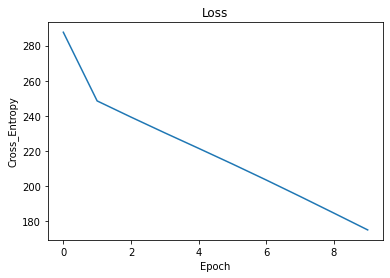

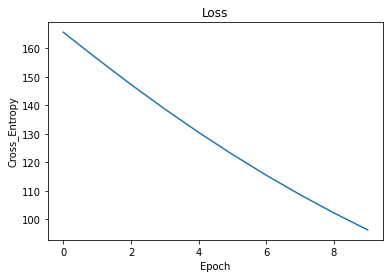

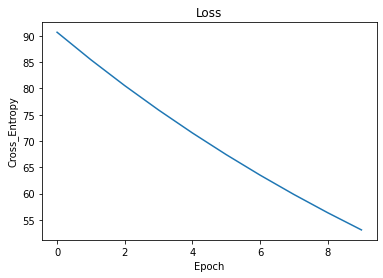

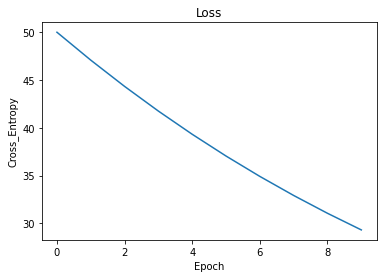

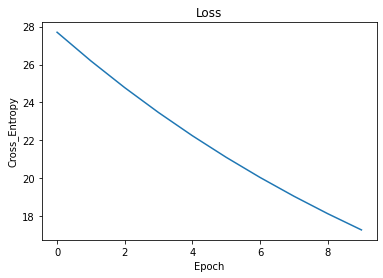

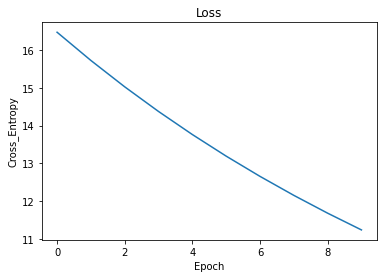

1 loop, best of 5: 25.6 s per loop


In [41]:
%%timeit
h = model.train(X[:100], Y[0:100], 10, learning_rate=0.1)
plt.plot(h)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross_Entropy")
plt.show()

#Vectorized

##Using Numpy

In [42]:
class MLP:

  def __init__(self, input_size, layers, loss = 'SqE'):
    self.n_features = input_size
    self.layer_info = layers
    self.loss = loss
    
    #Weights List
    self.weights = [np.random.randn(input_size, layers[0])]
    for i in range(len(layers)-1):
      self.weights.append(np.random.randn(layers[i], layers[i+1]))

    #Bias List
    self.bias = [np.random.randn(1, i) for i in layers]

    #Del terms for each layer
    self.delta = [np.zeros([1, i]) for i in layers]

    #Activated Output of Each Layer
    self.a = [np.zeros([1, input_size])]
    self.a.extend([np.zeros([1, i]) for i in layers])


  def forward_prop(self, features):

    self.a[0] = np.array(features).reshape(1, -1)

    for i in range(len(self.weights)-1):
      self.a[i+1] = np.dot(self.a[i], self.weights[i]) + self.bias[i]
      self.a[i+1] = self.sigmoid(self.a[i+1])
  
    self.a[-1] = np.dot(self.a[-2], self.weights[-1]) + self.bias[-1]
    self.a[-1] = self.softmax(self.a[-1])

    return self.a[-1]


  def train(self, inputs, outputs, epochs = 10, learning_rate = 0.01):

    history = []
    for _ in range(epochs):
      cost = 0
      for i in range(inputs.shape[0]):
        cost += self.backprop(inputs[i], outputs[i], learning_rate)
      history.append(cost)
    
    return history


  def backprop(self, input, output, lr):

    y_hat = self.forward_prop(input)

    if(self.loss == "SqE"):
      cost = self.SqE(output, y_hat)
      self.delta[-1] = (y_hat - output)  *  (self.a[-1]* (1 - self.a[-1]))
    else:
      cost = self.cross_entropy(output, y_hat)
      self.delta[-1] = self.a[-1] * np.sum(self.a[-1])  - output 


    for i in range(len(self.weights)-1, 0, -1):
      self.delta[i-1] = np.dot(self.delta[i],self.weights[i].T)  *  (self.a[i] * (1 - self.a[i]))
      self.weights[i] -= lr*np.dot(self.a[i].T,self.delta[i])
      self.bias[i] -= lr*self.delta[i]

    self.weights[0] -= lr*np.dot(self.a[0].T,self.delta[0])
    self.bias[0] -= lr*self.delta[0]

    return cost


  def sigmoid(self, input):
    return 1 / (1 + np.exp(-input))


  def predict(self, input):
    return np.argmax(self.forward_prop(input))


  def softmax(self, input):
    x = np.exp(input)
    sum = np.sum(x)
    return x/sum


  def SqE(self, y, y_hat):
    return np.sum(0.5*(y-y_hat)**2)


  def cross_entropy(self, y, y_hat):
    return -1*np.sum(y*np.log(y_hat))


In [43]:
model = MLP(784, [16, 10], loss = 'cross_entropy')

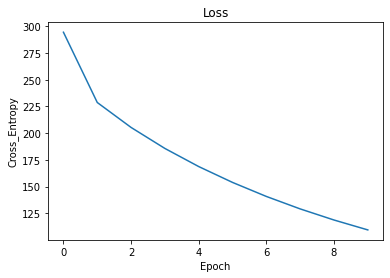

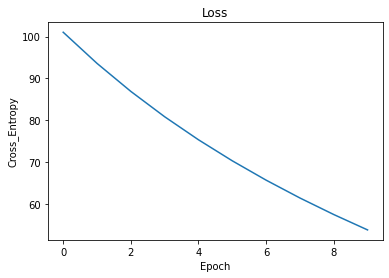

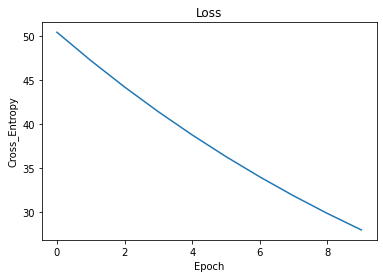

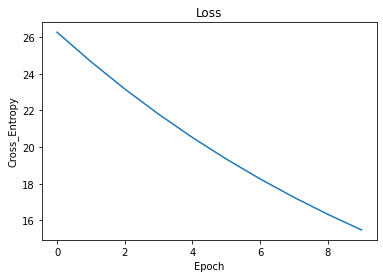

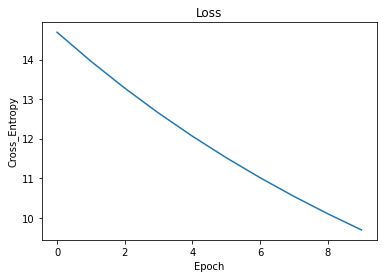

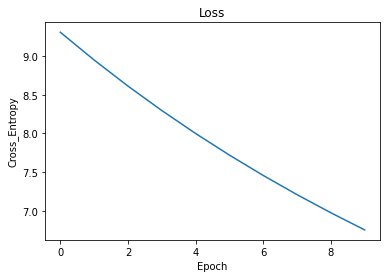

1 loop, best of 5: 346 ms per loop


In [44]:
%%timeit
h = model.train(X[:100], Y[0:100], 10, learning_rate=0.1)
plt.plot(h)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross_Entropy")
plt.show()

##Using Torch Tensor

In [45]:
class MLP:

  def __init__(self, input_size, layers, loss = 'SqE'):
    self.n_features = input_size
    self.layer_info = layers
    self.loss = loss
    
    #Weights List
    self.weights = [torch.randn(input_size, layers[0]).double()]
    for i in range(len(layers)-1):
      self.weights.append(torch.randn(layers[i], layers[i+1]).double())

    #Bias List
    self.bias = [torch.randn(1, i).double() for i in layers]

    #Del terms for each layer
    self.delta = [torch.zeros([1, i]).double() for i in layers]

    #Activated Output of Each Layer
    self.a = [torch.zeros([1, input_size]).double()]
    self.a.extend([torch.zeros([1, i]).double() for i in layers])


  def forward_prop(self, features):

    self.a[0] = torch.from_numpy(features).reshape(1, -1)

    for i in range(len(self.weights)-1):
      self.a[i+1] = torch.matmul(self.a[i], self.weights[i]) + self.bias[i]
      self.a[i+1] = self.sigmoid(self.a[i+1])
  
    self.a[-1] = torch.matmul(self.a[-2], self.weights[-1]) + self.bias[-1]
    self.a[-1] = self.softmax(self.a[-1])

    return self.a[-1]


  def train(self, inputs, outputs, epochs = 10, learning_rate = 0.01):

    history = []
    for _ in range(epochs):
      cost = 0
      for i in range(inputs.shape[0]):
        cost += self.backprop(inputs[i], outputs[i], learning_rate)
      history.append(cost)
    
    return history


  def backprop(self, input, output, lr):

    y_hat = self.forward_prop(input)

    if(self.loss == "SqE"):
      cost = self.SqE(output, y_hat)
      self.delta[-1] = (y_hat - output)  *  (self.a[-1]* (1 - self.a[-1]))
    else:
      cost = self.cross_entropy(output, y_hat)
      self.delta[-1] = self.a[-1] * torch.sum(self.a[-1])  - output 


    for i in range(len(self.weights)-1, 0, -1):
      self.delta[i-1] = torch.matmul(self.delta[i],self.weights[i].T)  *  (self.a[i] * (1 - self.a[i]))
      self.weights[i] -= lr*torch.matmul(self.a[i].T,self.delta[i])
      self.bias[i] -= lr*self.delta[i]

    self.weights[0] -= lr*torch.matmul(self.a[0].T,self.delta[0])
    self.bias[0] -= lr*self.delta[0]

    return cost


  def sigmoid(self, input):
    return 1 / (1 + torch.exp(-input))


  def predict(self, input):
    return torch.argmax(self.forward_prop(input))


  def softmax(self, input):
    x = torch.exp(input)
    sum = torch.sum(x)
    return x/sum


  def SqE(self, y, y_hat):
    return torch.sum(0.5*(y-y_hat)**2)


  def cross_entropy(self, y, y_hat):
    return -1*torch.sum(y*torch.log(y_hat))


In [48]:
model = MLP(784, [64, 32, 10], loss = 'cross_entropy')

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

X = x_train.reshape(-1, 784)
Y = torch.zeros([y_train.shape[0], 10])
X = tf.keras.utils.normalize(X, axis = 1)

for i in range(Y.shape[0]):
  Y[i][y_train[i]] = 1

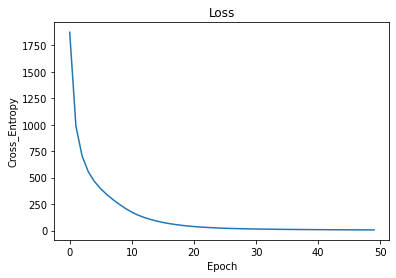

In [49]:
h = model.train(X[:1000], Y[0:1000], 50, learning_rate=0.1)
plt.plot(h)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross_Entropy")
plt.show()

Text(0.5, 1.0, 'Predicted: 0')

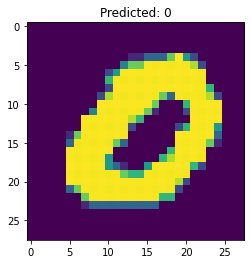

In [ ]:
i = 2009
plt.imshow(X[i].reshape(28,28))
plt.title('Predicted: '+str(model.predict(X[i]).item()))